 ## Imports

In [1]:
print("Importing lib....", flush=True)

import torch
from torch import nn
from transformers import MobileNetV2Config, MobileNetV2Model
import matplotlib.pyplot as plt

from PIL import Image
import os
import numpy as np
import torchvision.transforms as transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from matplotlib import pyplot as plt
import torch
from tqdm import tqdm

Importing lib....


/home2/pranav.agarwal/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
# assert DEVICE == "cuda:0"
print(f"Using {DEVICE} DEVICE",flush=True)

print("Libraries imported", flush=True)

Using cuda:0 DEVICE
Libraries imported


In [3]:
""" Normalization class """

norm_mean=[0.485, 0.456, 0.406]
norm_std=[0.229, 0.224, 0.225]
# unromalize the image
def unormalize_np_image(image, mean=norm_mean, std=norm_std):
    image = image * std + mean
    image = image * 255
    image = np.clip(image, 0, 255)
    image = image.astype(np.uint8)
    return image

In [4]:
""" ## Load Data """
print("Loading Data", flush=True)

types= ['light','dark']

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            images.append(img)
    return images

folder_path_shadow = f"./types-shadow/input"
folder_path_removed = f"./types-shadow/target"

img_shadow_types_ =[load_images_from_folder(f'{folder_path_shadow}/{type}')  for type in types]
img_removed_types_ = [load_images_from_folder(f'{folder_path_removed}/{type}') for type in types]

print('loaded images',flush=True)
transform = transforms.Compose([
    transforms.Resize((1024,768)),  # Ensure the size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

img_shadow_types = [torch.stack([transform(img) for img in img_shadow]) for img_shadow in img_shadow_types_]

img_removed_types = [torch.stack([transform(img) for img in img_removed]) for img_removed in img_removed_types_]


Loading Data
loaded images


In [5]:
del img_shadow_types_
del img_removed_types_

## Model Definition

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=2, do_up_sampling=True):
        # TODO: adding skip connections
        """
        Decoder block module.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            expansion (int, optional): Expansion factor. Default is 3.
        """
        super(DecoderBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)

        self.cnn1 = nn.Conv2d(in_channels, in_channels *
                              expansion, kernel_size=1, stride=1)
        self.bnn1 = nn.BatchNorm2d(in_channels*expansion)

        # nearest neighbor x2
        self.do_up_sampling = do_up_sampling
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # DW conv/ c_in*exp x 5 x 5 x c_in*exp
        self.cnn2 = nn.Conv2d(in_channels*expansion, in_channels *
                              expansion, kernel_size=5, padding=2, stride=1)
        self.bnn2 = nn.BatchNorm2d(in_channels*expansion)

        self.cnn3 = nn.Conv2d(in_channels*expansion,
                              out_channels, kernel_size=1, stride=1)
        self.bnn3 = nn.BatchNorm2d(out_channels)

        self.identity = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the decoder block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        temp_x = self.identity(x)
        x = self.cnn1(x)
        x = self.bnn1(x)
        x = self.relu(x)

        if self.do_up_sampling:
            x = self.upsample(x)
            temp_x = self.upsample(temp_x)

        x = self.cnn2(x)
        x = self.bnn2(x)
        x = self.relu(x)

        x = self.cnn3(x)
        x = self.bnn3(x)

        return x + temp_x


def get_encoderv2_layers():
    configuration = MobileNetV2Config()
    model = MobileNetV2Model(configuration)

    list_en = nn.ModuleList()
    encoder_layers_idx = [
        [0],
        [1, 2],
        [3, 4, 5],
        [6, 7, 8, 9],
        [10, 11, 12],
        [13, 14, 15],
    ]
    for idx, layer in enumerate(encoder_layers_idx):
        list_en.append(nn.Sequential(*[model.layer[i] for i in layer]))
    list_en.append(model.conv_1x1)
    return list_en, model.conv_stem


def get_decoderv2_layers():
    decoder_layers = nn.ModuleList()
    decoder_layers.append(DecoderBlock(1280, 320, do_up_sampling=False))
    decoder_layers.append(DecoderBlock(320+320, 160, do_up_sampling=False))
    decoder_layers.append(DecoderBlock(160+160, 96, do_up_sampling=True))
    decoder_layers.append(DecoderBlock(96+96, 64, do_up_sampling=False))
    decoder_layers.append(DecoderBlock(64+64, 32, do_up_sampling=True))
    decoder_layers.append(DecoderBlock(32+32, 24, do_up_sampling=True))
    decoder_layers.append(DecoderBlock(24+24, 16, do_up_sampling=True))

    # a conv layer to get the final output
    out_stem = nn.Sequential(
        nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=(1, 1),
                               stride=(1, 1), bias=False),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.997,
                           affine=True, track_running_stats=True),
            nn.ReLU6(),
        ),
        nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(
                1, 1), groups=32, bias=False, padding=1),
            nn.BatchNorm2d(32, eps=0.001, momentum=0.997,
                           affine=True, track_running_stats=True),
            nn.ReLU6(),
        ),
        nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(
                2, 2), bias=False, padding=1, output_padding=1),
            nn.BatchNorm2d(3, eps=0.001, momentum=0.997,
                           affine=True, track_running_stats=True),
        )
    )

    return decoder_layers, out_stem


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class CoordAtt(nn.Module):
    def __init__(self, inp, oup, reduction=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))

        mip = max(8, inp // reduction)

        self.conv1 = nn.Conv2d(inp, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()

        self.conv_h = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, oup, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identity = x

        n, c, h, w = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)

        x_h, x_w = torch.split(y, [h, w], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identity * a_w * a_h

        return out


In [7]:
class UnetV2WithAT(nn.Module):
    def __init__(self, lr=0.5):
        super(UnetV2WithAT, self).__init__()
        self.encoder_blocks, self.first_layer = get_encoderv2_layers()
        self.decoder_blocks, self.last_layer = get_decoderv2_layers()

        # encoder_blocks, image_stem_layer, image_processor = get_encoder_layers()
        # decoder_blocks = get_decoder_layers()

        # self.encoder_blocks = encoder_blocks
        # self.decoder_blocks = decoder_blocks

        # self.image_processor = image_processor
        # self.image_stem_layer = image_stem_layer
        self.lra = CoordAtt(3, 3)
        self.ldra = CoordAtt(3, 3)

        # self.out_image_stem_layer = nn.Sequential(
        #     nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2,
        #                        bias=False, padding=1, output_padding=1),
        #     nn.BatchNorm2d(3, eps=0.001, momentum=0.9997,
        #                    affine=True, track_running_stats=True),
        #     nn.ReLU()
        # )

        # self.loss2 = nn.

    def forward(self, x):
        """
        Performs forward pass through the U-Net model.

        Args:
                x (torch.Tensor): Input image tensor.
                process_image (bool): Whether to preprocess input image.

        Returns:
                torch.Tensor: Output image tensor.
        """
        assert x.shape[1] == 3, "input image should have 3 channels(nx3x224x224)"

        temp_in_x = x

        x = self.first_layer(x)

        enc_outputs = []
        for indx, enc_block in enumerate(self.encoder_blocks):
            x = enc_block(x)
            enc_outputs.append(x)

        for indx, dec_block in enumerate(self.decoder_blocks):
            if indx == 0:
                x = dec_block(x)

            else:
                x = dec_block(
                    torch.cat([x, enc_outputs[len(self.decoder_blocks) - indx - 1]], dim=1))

        x = self.last_layer(x)

        # lra attention on skip connection
        temp_in_x = self.lra(temp_in_x)
        # ldra attention on output
        x = self.ldra(x)

        return x + temp_in_x
    
    def predict(self,x):
        with torch.no_grad():
            return self(x)

class LPNet(nn.Module):
    def __init__(self, i2it_model_path, L=2, interp_mode='nearest-exact',lr=0.1):
        super(LPNet,self).__init__()

        self.L = L
        self.interp_mode = interp_mode
        self.final_input_dim = None
        
        self.i2it_model = nn.DataParallel(UnetV2WithAT(), device_ids=[0,1,2,3])
        self.i2it_model.load_state_dict(torch.load(i2it_model_path))
        for param in self.i2it_model.parameters():
            param.requires_grad_(False)
        # self.i2it_model.eval()

        self.resid_refinement_net = nn.Sequential(
            # Depth-sequential network
            nn.Conv2d(in_channels=9, out_channels=32, kernel_size=1),
            nn.LeakyReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, groups=32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1),
        )

        self.next_res_net = nn.ModuleList()
        for l in range(L-1):
            layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=1),
                nn.LeakyReLU(),

                nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1),
                nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1),
            )

            self.next_res_net.append(layers)

        self.loss_layer = nn.L1Loss()

        # self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self,I0):
        # print(f'a forward loop')
        '''
            Downsampling the original image
        '''
        H = []
        shapes = []
        IL = I0
        for l in range(self.L):
            curr_dim = IL.shape
            shapes.append(curr_dim)

            # print(f'Downsampling {IL.shape}')
            IL_next = nn.functional.interpolate(IL,size=[curr_dim[2]//2,curr_dim[3]//2],mode=self.interp_mode)
            IL_next_up = nn.functional.interpolate(IL_next,size=[curr_dim[2],curr_dim[3]],mode=self.interp_mode)
            Hl = IL - IL_next_up
            H.append(Hl)

            IL = IL_next
        
        self.final_input_dim = IL[0].shape
        # print(f'Downsampled {IL.shape}')
        '''
            I2IT
        '''
        IL_cap = self.i2it_model.module.predict(IL)
        # print(f'I2IT: {IL_cap.shape}')
        '''
            Upsampling the translated image
        '''
        
        IL_up = nn.functional.interpolate(IL,size=[shapes[self.L-1][2],shapes[self.L-1][3]],mode=self.interp_mode)
        IL_cap_up = nn.functional.interpolate(IL_cap,size=[shapes[self.L-1][2],shapes[self.L-1][3]],mode=self.interp_mode)
        ResNet_inp = torch.cat([IL_up, IL_cap_up, H[self.L-1]],dim=1)
        
        # Ml_next = torch.mean(torch.stack([IL_up, IL_cap_up, H[self.L-1]]),dim=0,keepdim=True)[0]
        Ml_next = self.resid_refinement_net(ResNet_inp)
        
        H_ref = H[self.L-1]*Ml_next
        Il_cap = H_ref + IL_cap_up
#         print(H_ref.shape,H[self.L-1].shape,Ml_next.shape)

        for l in range(self.L-2,-1,-1):
            Ml_next_up = nn.functional.interpolate(Ml_next,size=[shapes[l][2],shapes[l][3]],mode=self.interp_mode)
            Ml_next = self.next_res_net[l](Ml_next_up)
            
            Il_cap_up = nn.functional.interpolate(Il_cap,size=[shapes[l][2],shapes[l][3]],mode=self.interp_mode)
        
            H_ref = H[l]*Ml_next
            Il_cap = H_ref + Il_cap_up

        return Il_cap
    
    def loss(self,I0, I0_cap,):
        with  torch.no_grad():

            I0_cap_pred = self(I0.to(DEVICE))
            loss = self.loss_layer(I0_cap_pred, I0_cap.to(DEVICE))

            return loss.item()
        
    def predict(self,I0):
        with  torch.no_grad():
            return self(I0.to(DEVICE))
     

## Accuracy metrics


In [8]:
def accuracy(model, x, y):
    metric = SSIM().to(DEVICE)
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    with torch.no_grad():
        pred = model(x)
        return metric(pred, y)

## Loading Model and Training

In [9]:
torch.cuda.empty_cache()
model = nn.DataParallel(LPNet('./models/v2-shadrem-att.pth'), device_ids=[0,1,2,3])
model.load_state_dict(torch.load('./models/v2_lpnet_shadrem-att.pth'))
model = model.to(DEVICE)

for param in model.module.parameters():
    param.requires_grad_(False)
model.eval()

param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters = {total_params/1e6} M',flush=True)
print(f'Trainable parameters = {trainable_params}',flush=True)

print("Model loaded", flush=True)


Total parameters = 229.373044 M
Trainable parameters = 0
Model loaded


In [10]:
total_acc = 0
total_images = 0
accuracies = [] 
batch_size = 32

for i in range(len(types)):
    test_dataset = torch.utils.data.TensorDataset(img_shadow_types[i], img_removed_types[i])
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    type_acc = 0
    n_type = 0
    for x_test, y_test in tqdm(test_loader):
        acc = accuracy(model,x_test,y_test)
        type_acc+= acc.item()*x_test.shape[0]
        n_type+= x_test.shape[0]
    
    total_images+= n_type
    total_acc+= type_acc
    accuracies.append(type_acc/n_type)
    
total_acc/= total_images
print(total_images)
print(total_acc)

100%|██████████| 3/3 [00:02<00:00,  1.44it/s]

192
0.9506292144457499


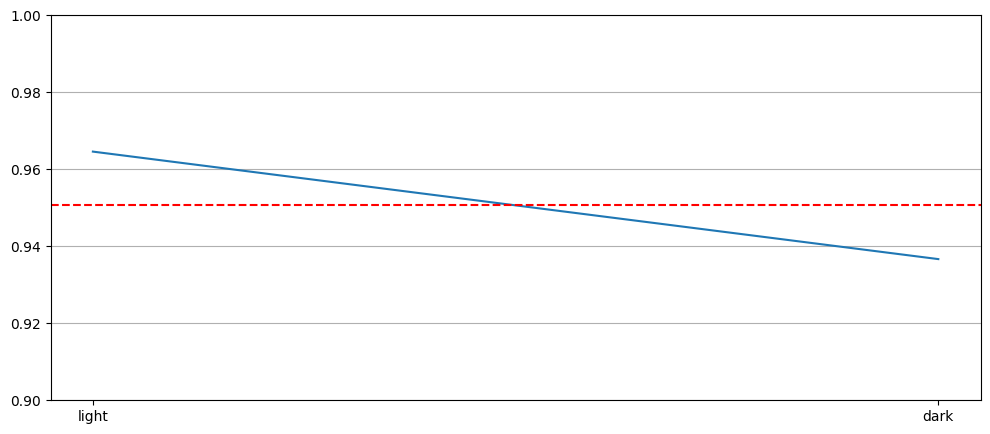

In [11]:
plt.figure(figsize=(12,5))
plt.plot([type for type in types],accuracies)
plt.axhline(y=total_acc, c='red',linestyle='--')

plt.ylim([0.9,1])
plt.grid(axis='y')


plt.show()

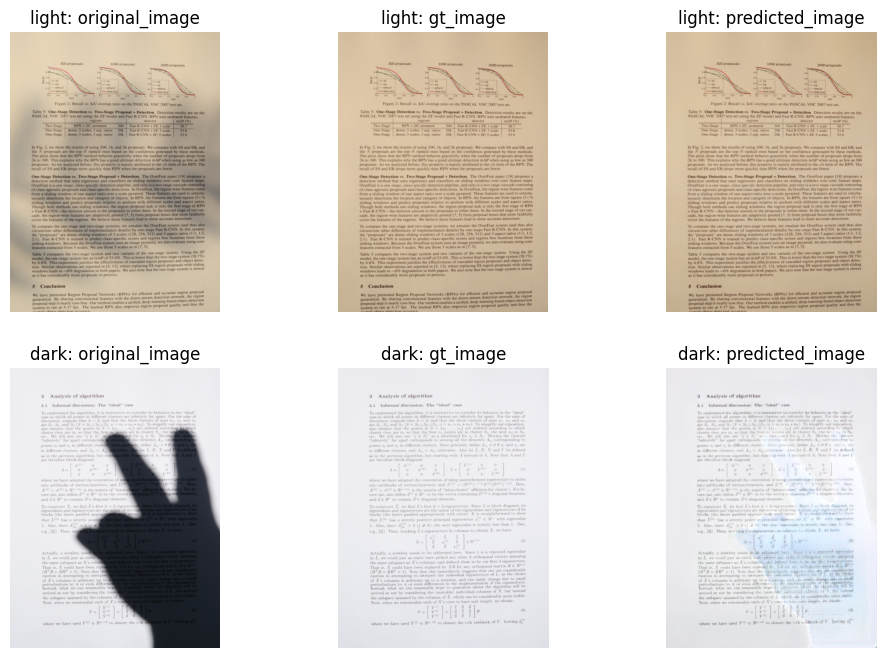

In [13]:
fig, axes = plt.subplots(len(types), 3, figsize=(4*3, 4*len(types)))


for i in range(len(types)):
    # img_shadow_types
    # img_removed_types
    x_vis = img_shadow_types[i]
    y_vis = img_removed_types[i]
    idx=1
    # Extract the original image and convert it to numpy array
    original_image = x_vis[idx].permute(1, 2, 0).cpu().numpy()
    gt_image = y_vis[idx].permute(1, 2, 0).cpu().numpy()

    # Compute the predicted image using the model
    predicted_image = model.module.predict(x_vis[idx].unsqueeze(0)).cpu().detach().squeeze(0).permute(1, 2, 0).numpy()

    # unormalize the image
    original_image = unormalize_np_image(original_image)
    gt_image = unormalize_np_image(gt_image)
    predicted_image = unormalize_np_image(predicted_image)

    # Plot the first image
    axes[i][0].imshow(original_image,)
    axes[i][0].set_title(f'{types[i]}: original_image')
    axes[i][0].set_axis_off()

    # Plot the second image
    axes[i][1].imshow(gt_image,)
    axes[i][1].set_title(f'{types[i]}: gt_image')
    axes[i][1].set_axis_off()

    # Plot the third image
    axes[i][2].imshow(predicted_image,)
    axes[i][2].set_title(f'{types[i]}: predicted_image')
    axes[i][2].set_axis_off()
            